# Polarization example (GRB) - azimuthal scattering angle distribution (ASAD) method

This notebook fits the polarization fraction and angle of a GRB simulated using MEGAlib and combined with background. It's assumed that the start time, duration, localization, and spectrum of the GRB are already known. The GRB was simulated with 70% polarization at an angle of 110 degrees in the RelativeX convention, which corresponds to 83.015 degrees in the IAU convention.

The data to run this notebook, including GRBs simulated on-axis, 10 degrees off-axis, and 20 degrees off-axis, can be found on the COSI Pipeline Google Drive: https://drive.google.com/drive/folders/1kCkqQv07APSSlexeuIgK2Jj7eqJzNNgQ. However, with the RelativeZ response, it is not possible to fit the on-axis GRB.

Caveats/limitations:
- Currently, the source must be stationary with respect to the instrument, and the spacecraft must be stationary. The ability to fit the polarization of persistent sources will be added later. 
- The background simulation is used as the background model, and its ASAD is subtracted from the source+background ASAD.   

In [1]:
from cosipy import UnBinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.polarization.conventions import MEGAlibRelativeX, MEGAlibRelativeY, MEGAlibRelativeZ, IAUPolarizationConvention
from polarization.polarization_asad import PolarizationASAD, calculate_uncertainties
from cosipy.threeml.custom_functions import Band_Eflux
from astropy.time import Time
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from astropy import units as u
from scoords import SpacecraftFrame
from scipy.optimize import curve_fit

Welcome to JupyROOT 6.28/02


01:03:48 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=55875;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=503714;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=490485;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=240777;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=980841;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=843109;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=130818;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=541098;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=634118;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=457889;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=468337;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=192510;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=78448;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=912498;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

01:03:48 WARNING   Multinest minimizer not available                                           ]8;id=564039;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=701642;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=582139;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=777222;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

01:03:49 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=481954;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=825041;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=126626;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=684220;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=844329;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=222836;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

01:03:49 WARNING   No fermitools installed                                              ]8;id=123326;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=545392;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=451603;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=636257;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=582927;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=991721;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=828668;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=475847;file:///Users/eneights/opt/anaconda3/envs/cosipy-pr/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

Read in the data (GRB+background), background simulation, and define the path to the detector response

In [2]:
analysis = UnBinnedData('/path/to/yaml/file') # e.g. grb.yaml

analysis.select_data(unbinned_data='/path/to/data/file', output_name='/path/to/selected/data/file') # e.g. GRB_20_0.hdf5 & GRB_20_0_selected.hdf5
data = analysis.get_dict_from_hdf5('/path/to/selected/data/file') # e.g. GRB_20_0_selected.hdf5
background = analysis.get_dict_from_hdf5('/path/to/background/file') # e.g. background.hdf5

response_file = '/path/to/response/file' # e.g. HEALPixO3_200to500keV_1ebins_12pbins_log_flat.binnedpolarization.11D_nside8.area.h5

Read in the orientation file. Here, the spacecraft is stationary, so we are only using the first attitude bin

In [3]:
sc_orientation = SpacecraftFile.parse_from_file('/path/to/ori/file') # e.g. ori.ori
sc_orientation = sc_orientation.source_interval(Time(analysis.tmin,format = 'unix'), Time(analysis.tmax,format = 'unix'))

attitude = sc_orientation.get_attitude()[0]

Define the GRB spectrum. This is convolved with the response to calculate the ASADs of an unpolarized and 100% polarized source

In [4]:
a = 10. * u.keV
b = 5000. * u.keV
alpha = 0.880
beta = -2.384
ebreak = 195.613 * u.keV
K = 10. / u.cm / u.cm / u.s

spectrum = Band_Eflux(a = a.value,
                      b = b.value,
                      alpha = alpha,
                      beta = beta,
                      E0 = ebreak.value,
                      K = K.value)

spectrum.a.unit = a.unit
spectrum.b.unit = b.unit
spectrum.E0.unit = ebreak.unit
spectrum.K.unit = K.unit

Define the source position and polarization object

In [6]:
source_direction = SkyCoord(0, 70, representation_type='spherical', frame=SpacecraftFrame(attitude=attitude), unit=u.deg)

grb_polarization = PolarizationASAD(source_direction, spectrum, response_file, sc_orientation)

Calculate the azimuthal scattering angle for each photon in the data and background simulation

In [7]:
azimuthal_angles = {}
    
azimuthal_angles['grb & background'] = grb_polarization.calculate_azimuthal_scattering_angles(data)
azimuthal_angles['background'] = grb_polarization.calculate_azimuthal_scattering_angles(background)

Create an azimuthal scattering angle distribution (ASAD) each for the data and background simulation

In [8]:
bin_edges = Angle(np.linspace(-np.pi, np.pi, 18), unit=u.rad) # Define ASAD bins

asads = {}
for key in azimuthal_angles.keys():
    asads[key] = grb_polarization.create_asad(azimuthal_angles[key], bin_edges)

Calculate the ASAD of the GRB only by subtracting the background ASAD from the GRB+background ASAD

In [9]:
source_duration = analysis.tmax - analysis.tmin # Duration of GRB simulation
background_duration = np.max(background['TimeTags']) - np.min(background['TimeTags']) # Duration of background simulation

background_asad_grb_duration = (asads['background']['counts'] * source_duration / background_duration).astype(int)
grb_asad = asads['grb & background']['counts'] - background_asad_grb_duration

asads['grb'] = {'counts': grb_asad, 'uncertainties': calculate_uncertainties(grb_asad)}

Calculate the unpolarized and 100% polarized ASADs, and calculate the modulation of a 100% polarized source

Polarization angle bin: 0.0 deg to 15.0 deg
Modulation: 0.309 +/- 0.003
Best fit polarization fraction: 1.0 +/- 0.016
Best fit polarization angle: 160.234 +/- 0.3


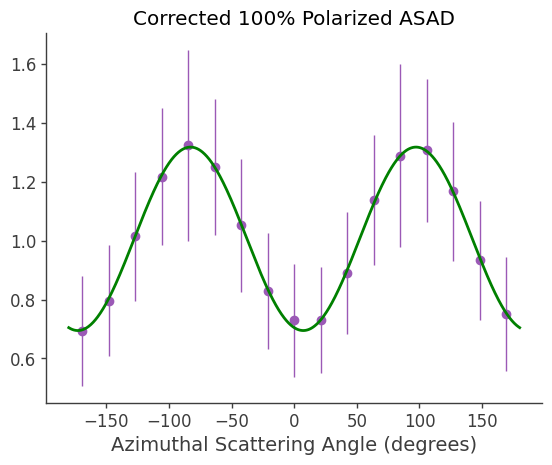

Polarization angle bin: 15.0 deg to 30.0 deg
Modulation: 0.31 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.018
Best fit polarization angle: 175.396 +/- 0.344


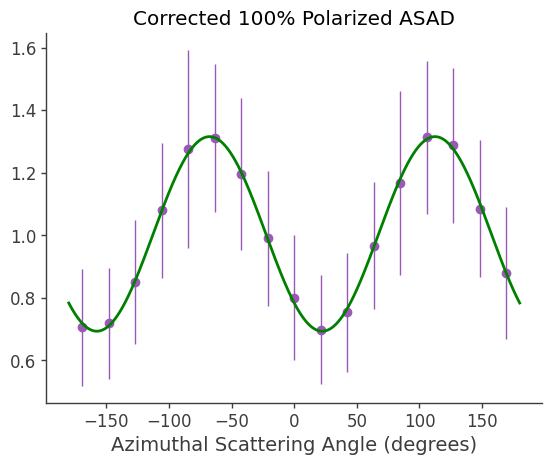

Polarization angle bin: 30.0 deg to 45.0 deg
Modulation: 0.307 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.018
Best fit polarization angle: 10.124 +/- 0.367


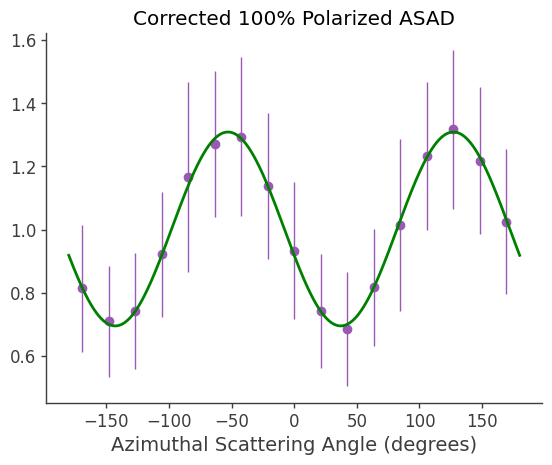

Polarization angle bin: 45.0 deg to 60.0 deg
Modulation: 0.309 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.017
Best fit polarization angle: 25.51 +/- 0.349


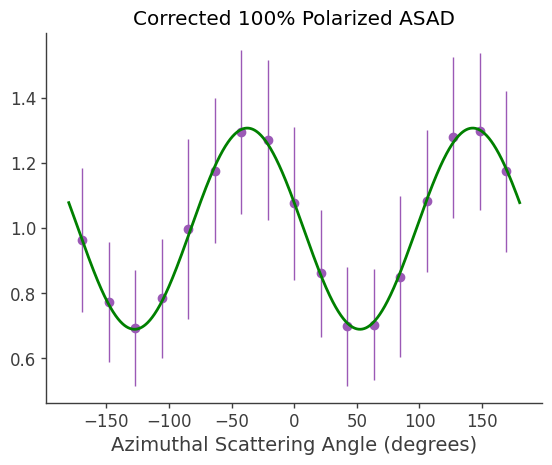

Polarization angle bin: 60.0 deg to 75.0 deg
Modulation: 0.307 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.018
Best fit polarization angle: 40.702 +/- 0.364


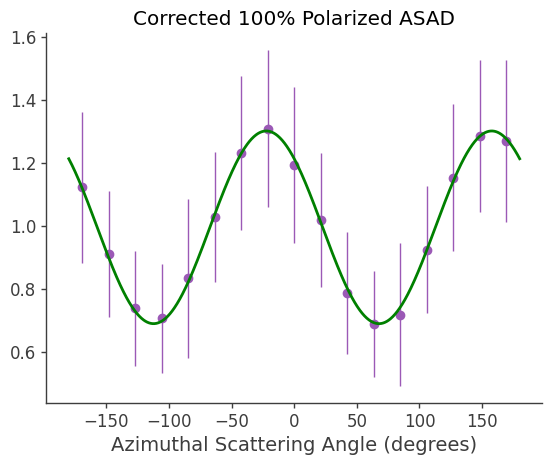

Polarization angle bin: 75.0 deg to 90.0 deg
Modulation: 0.312 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.017
Best fit polarization angle: 55.409 +/- 0.329


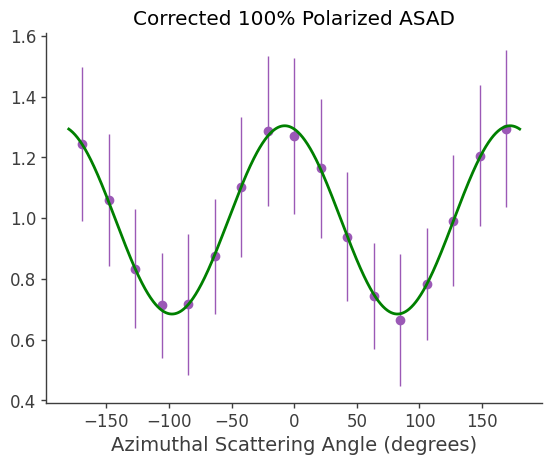

Polarization angle bin: 90.0 deg to 105.0 deg
Modulation: 0.313 +/- 0.003
Best fit polarization fraction: 1.0 +/- 0.014
Best fit polarization angle: 70.287 +/- 0.271


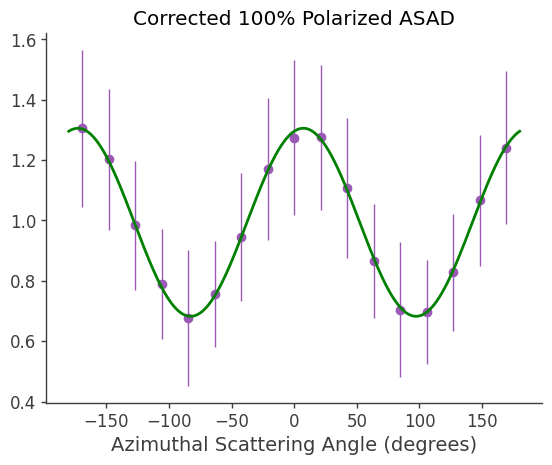

Polarization angle bin: 105.0 deg to 120.0 deg
Modulation: 0.312 +/- 0.003
Best fit polarization fraction: 1.0 +/- 0.016
Best fit polarization angle: 85.277 +/- 0.312


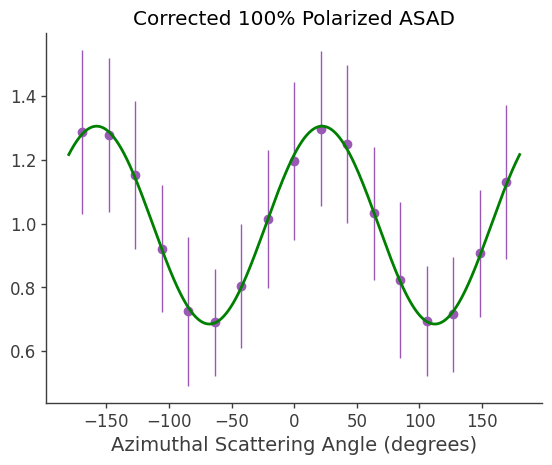

Polarization angle bin: 120.0 deg to 135.0 deg
Modulation: 0.306 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.021
Best fit polarization angle: 100.21 +/- 0.429


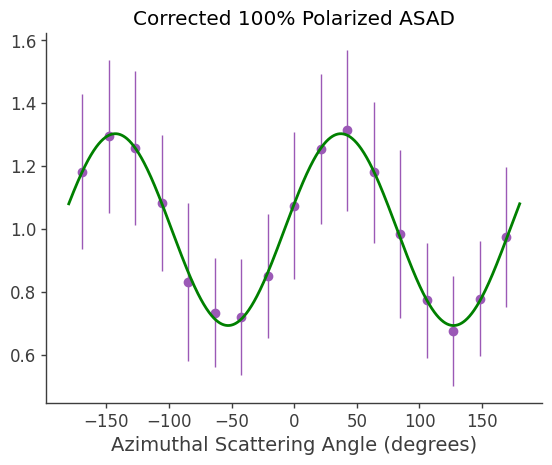

Polarization angle bin: 135.0 deg to 150.0 deg
Modulation: 0.309 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.018
Best fit polarization angle: 115.465 +/- 0.373


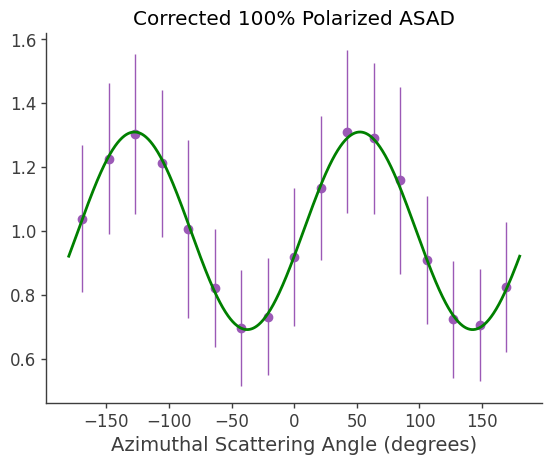

Polarization angle bin: 150.0 deg to 165.0 deg
Modulation: 0.308 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.017
Best fit polarization angle: 130.659 +/- 0.332


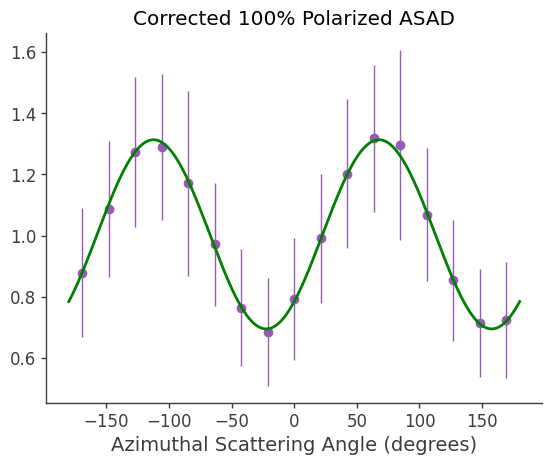

Polarization angle bin: 165.0 deg to 180.0 deg
Modulation: 0.309 +/- 0.004
Best fit polarization fraction: 1.0 +/- 0.019
Best fit polarization angle: 145.507 +/- 0.353


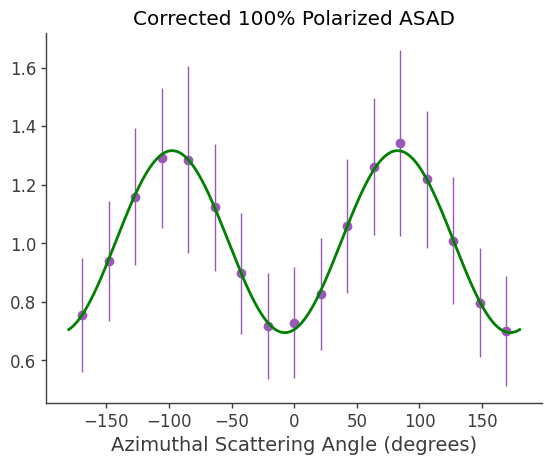

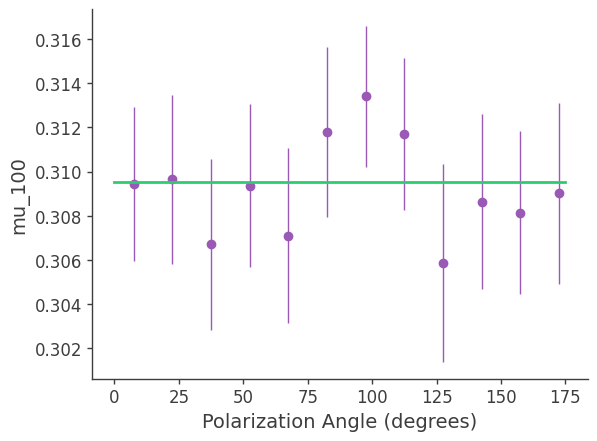

mu_100: 0.31


In [10]:
asads['unpolarized'] = grb_polarization.create_unpolarized_asad()

asads['polarized'] = grb_polarization.create_polarized_asads()

mu_100 = grb_polarization.calculate_mu100(asads['polarized'], asads['unpolarized'])

Plot the ASADs

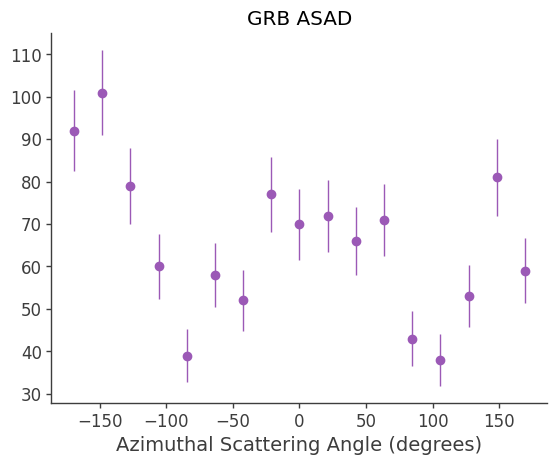

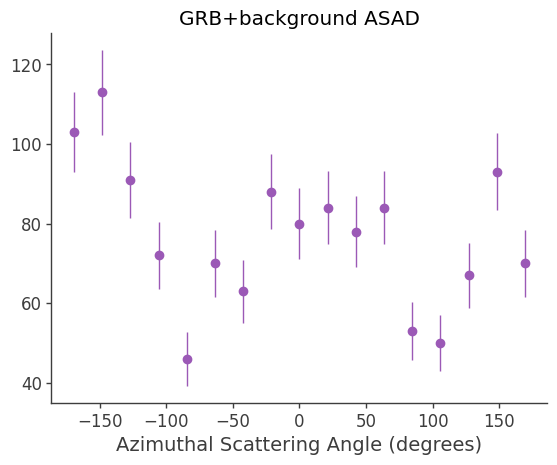

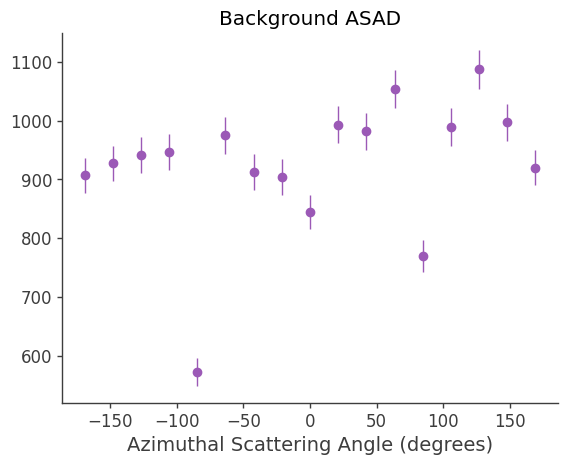

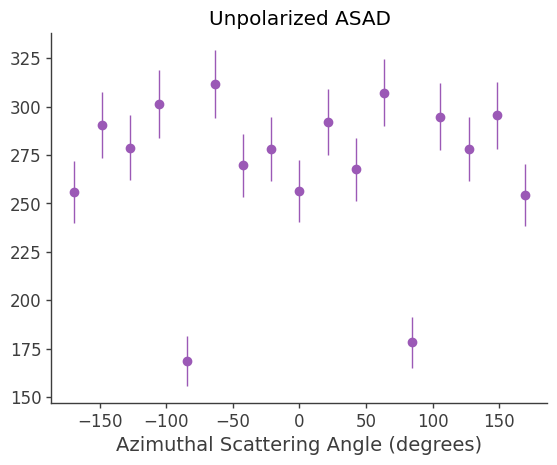

In [11]:
titles = {'grb': 'GRB ASAD', 'grb & background': 'GRB+background ASAD', 'background': 'Background ASAD', 'unpolarized': 'Unpolarized ASAD'}
for key in titles.keys():
    grb_polarization.plot_asad(asads[key]['counts'], asads[key]['uncertainties'], titles[key])

Divide the GRB ASAD by the unpolarized ASAD to correct for instrumental effects

In [12]:
asad_corrected = grb_polarization.correct_asad(asads['grb'], asads['unpolarized'])

Calculate the minimum detectable polarization (MDP) of the GRB 

In [13]:
source_counts = np.sum(asads['grb']['counts'])
background_counts = np.sum(background_asad_grb_duration)

mdp = 4.29 / mu_100['mu'] * np.sqrt(source_counts + background_counts) / source_counts

Fit the polarization fraction and angle of the GRB

In [14]:
polarization = grb_polarization.fit(mu_100, asad_corrected['counts'], bounds=([0, 0, 0], [np.inf,np.inf,np.pi]), sigma=asad_corrected['uncertainties'])

if mdp > polarization['fraction']:
    print('Polarization fraction is below MDP!', 'MDP:', round(mdp, 3))
else:
    print('MDP:', round(mdp, 3))

Best fit polarization fraction: 0.88 +/- 0.183
Best fit polarization angle: 80.116 +/- 5.942
MDP: 0.451 



Plot the corrected ASAD for the GRB with the best fit sinusoidal function

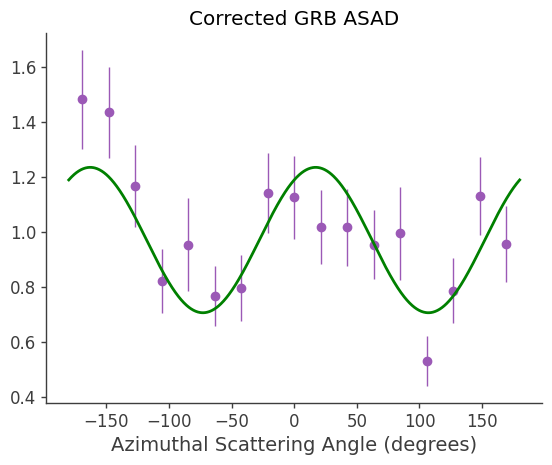

In [15]:
grb_polarization.plot_asad(asad_corrected['counts'], asad_corrected['uncertainties'], 'Corrected ' + titles['grb'], coefficients=polarization['best fit parameter values'])

Transform polarization angle to different conventions

In [16]:
print('RelativeX:', round(polarization['angle'].transform_to(MEGAlibRelativeX(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeY:', round(polarization['angle'].transform_to(MEGAlibRelativeY(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeZ:', round(polarization['angle'].transform_to(MEGAlibRelativeZ(attitude=attitude)).angle.degree, 3), 'degrees')
print('IAU:', round(polarization['angle'].transform_to(IAUPolarizationConvention()).angle.degree, 3), 'degrees')

RelativeX: 107.101 degrees
RelativeY: 17.101 degrees
RelativeZ: 107.101 degrees
IAU: 80.116 degrees
